<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

#Поработаем с данными. Разберемся с моделями.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
import datasets
from datasets import Dataset
import evaluate
from typing import Optional

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR


from transformers import AutoTokenizer, AutoModel
from typing import Union

import pandas as pd
import numpy as np

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [ ]:
data = pd.read_excel('data_problems.xlsx')

In [ ]:
texts = data['Задача']
labels = data['Тема'].astype('category').cat.codes

In [ ]:
num_of_classes = labels.value_counts()

In [ ]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_of_classes: int):
        super().__init__()
        self.backbone = base_transformer_model
        self.classificator = nn.Linear(312, num_of_classes)
        # YOUR CODE: create additional layers for classfication

    def forward(self, input_ids, token_type_ids = None, attention_mask=None, labels=None):
        # Pass input_ids and attention_mask to the backbone model
        outputs_from_BERT = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        #print(utputs_from_BERT.shape)
        # Use the pooled output for classification
        logits = self.classificator(outputs_from_BERT.pooler_output)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for p in model.backbone.parameters():
      p.requeres_grad = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
#Обернем данные в датасет, чтобы удобно разделить на трейн, вал, обернуть в даталоадер.
data['Тема'] = labels
data = data.rename(columns={'Тема': 'label', 'Задача': 'text'})
data = data.drop(columns=['Unnamed: 0'])
ds = Dataset.from_pandas(data)

###Теперь токенизируем тексты, подготовим данные для обучения.



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [ ]:
def tokenize_function (example):
  return tokenizer(example["text"], padding="max_length", truncation=True)

In [ ]:
tokenized_dataset = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/5273 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_ds = split_dataset['train']
test_ds = split_dataset['test']
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(train_ds, batch_size=16, shuffle=False)

In [ ]:
model_for_func = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model = TransformerClassificationModel(model_for_func, 7)

optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import copy
from tqdm import tqdm
def train_transformer(transformer_model, freeze_backbone, epochs, optimizer, train_loader, val_loader, metric, scheduler):
    model = copy.copy(transformer_model)
    if freeze_backbone:
      model = freeze_backbone_function(model)
    accs_for_epochs = []
    losses_all=[]
    losses_for_epochs = []
    for _ in range(epochs):
      accuracys = []
      losses=[]
      pbar = tqdm(train_loader, desc="Батчи", unit="batch", leave=False)
      model.train()
      for batch in pbar:
          optimizer.zero_grad()
          batch = {k: v.to(device) for k, v in batch.items()}
          outputs = model(**batch)
          outputs['loss'].backward()
          loss = outputs['loss'].cpu()
          losses_all.append(loss.item())
          losses.append(loss.item())

          optimizer.step()
          optimizer.zero_grad()
          pbar.set_postfix({"Loss": loss.item()})
      for batch in val_loader:
        with torch.no_grad():
          model.eval()
          batch = {k: v.to(device) for k, v in batch.items()}
          outputs = model(**batch)
          logits = outputs['logits'].cpu()
          preds = np.argmax(logits, axis=-1).cpu().numpy()
          reference = batch['labels'].cpu().numpy()
          accuracy = metric.compute (predictions = preds, references=reference)
          accuracys.append(accuracy['accuracy'])

      accs_for_epochs.append(sum(accuracys)/len(accuracys))
      losses_for_epochs.append(sum(losses)/len(losses))
      scheduler.step()


    result = {'model': model, 'accuracy':accs_for_epochs, 'losses':losses_all , 'losses_for_epochs':losses_for_epochs}

    return result

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
model_for_func = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
metric = evaluate.load("accuracy")

rubert_tiny_transformer_model = TransformerClassificationModel(model_for_func, 7)
result_1 = train_transformer(rubert_tiny_transformer_model.to(device), True, 2, optimizer, train_loader, test_loader, metric, scheduler)
rubert_tiny_finetuned_with_freezed_backbone = result_1['model']

rubert_tiny_transformer_model = TransformerClassificationModel(model_for_func, 7)
optimizer = Adam(rubert_tiny_transformer_model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

result_2 = train_transformer(rubert_tiny_transformer_model.to(device), False, 2, optimizer, train_loader, test_loader, metric, scheduler)
rubert_tiny_full_finetuned = result_2['model']


In [ ]:
print(result_1['accuracy'])
print(result_2['accuracy'])

[0.750189393939394, 0.7811079545454546]
[0.6899147727272726, 0.7568181818181818]


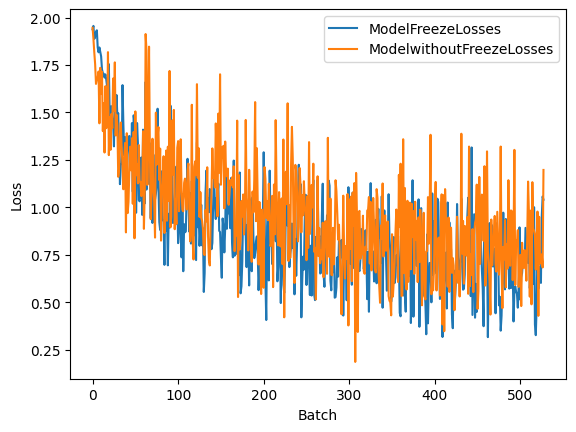

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(result_1['losses'])), result_1['losses'], label='ModelFreezeLosses')
plt.plot(range(len(result_2['losses'])), result_2['losses'], label='ModelwithoutFreezeLosses')

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

##Можем видеть, что модель,слои которой замораживались, дает лучший результат. Вероятно, ситуация изменилась, если бы мы увеличили количество эпох.

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [ ]:
from transformers import BertTokenizer
from transformers import BertModel

tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

In [ ]:
data_tr = pd.read_excel('data_problems_translated.xlsx')

In [ ]:
data_tr.head()

,Unnamed: 0,problem_text,topic
0,0,To prove that the sum of the numbers of the ex...,number_theory
1,1,( b) Will the statement of the previous challe...,number_theory
2,2,The quadratic three-member graph with the coef...,polynoms
3,3,Can you draw on the surface of Rubik's cube a ...,combinatorics
4,4,"Dima, who came from Vrunlandia, said that ther...",graphs


In [ ]:
texts = data_tr['problem_text']
labels = data_tr['topic'].astype('category').cat.codes
#Обернем данные в датасет, чтобы удобно разделить на трейн, вал, обернуть в даталоадер.
data_tr['Тема'] = labels
data_tr = data_tr.rename(columns={'Тема': 'label', 'problem_text': 'text'})
data_tr = data_tr.drop(columns=['Unnamed: 0'])
ds_tr = Dataset.from_pandas(data_tr)
ds_tr = ds_tr.filter(lambda example: example['text'] is not None)

Filter:   0%|          | 0/5273 [00:00<?, ? examples/s]

In [ ]:
def tokenize_function (example):
  return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

In [ ]:
tokenized_dataset_translate = ds_tr.map(tokenize_function, batched=True)

Map:   0%|          | 0/5268 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_translate = tokenized_dataset_translate.remove_columns(["text", "topic"])
tokenized_dataset_translate = tokenized_dataset_translate.rename_column("label", "labels")
tokenized_dataset_translate.set_format("torch")
split_dataset_translate = tokenized_dataset_translate.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_ds_translate = split_dataset_translate['train']
test_ds_translate = split_dataset_translate['test']
train_loader_translate = DataLoader(train_ds_translate, batch_size=16, shuffle=True)
test_loader_translate = DataLoader(test_ds_translate, batch_size=16, shuffle=False)

In [ ]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_of_classes: int):
        super().__init__()
        self.backbone = base_transformer_model
        self.classificator = nn.Linear(768, num_of_classes)
        # YOUR CODE: create additional layers for classfication

    def forward(self, input_ids, token_type_ids = None, attention_mask=None, labels=None):
        # Pass input_ids and attention_mask to the backbone model
        outputs_from_BERT = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        #print(utputs_from_BERT.shape)
        # Use the pooled output for classification
        logits = self.classificator(outputs_from_BERT.pooler_output)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

In [ ]:
model_for_func = BertModel.from_pretrained("tbs17/MathBERT")
metric = evaluate.load("accuracy")

math_bert_model = TransformerClassificationModel(model_for_func, 7)
optimizer = Adam(math_bert_model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
result_3 = train_transformer(math_bert_model.to(device), True, 2, optimizer, train_loader_translate, test_loader_translate, metric, scheduler)
math_bert_with_freezed_backbone = result_3['model']

math_bert_model = TransformerClassificationModel(model_for_func, 7)
optimizer = Adam(math_bert_model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

result_4 = train_transformer(math_bert_model.to(device).to(device), False, 2, optimizer, train_loader_translate, test_loader_translate, metric, scheduler)
math_bert_full_finetuned = result_4['model']

In [ ]:
print(result_3['accuracy'])
print(result_4['accuracy'])

[0.5791396103896104, 0.629193722943723]
[0.6216179653679654, 0.6424512987012987]


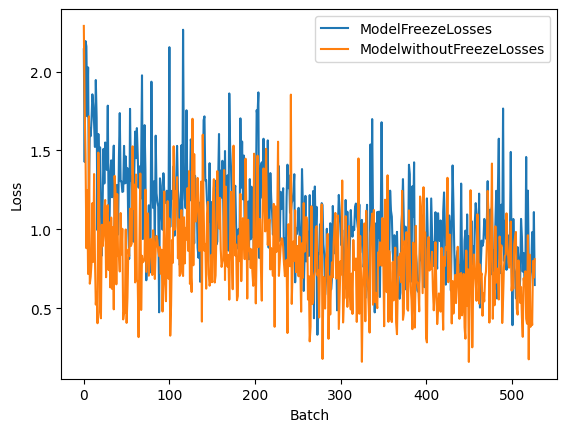

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(result_3['losses'])), result_3['losses'], label='ModelFreezeLosses')
plt.plot(range(len(result_4['losses'])), result_4['losses'], label='ModelwithoutFreezeLosses')

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

Скоры получились на порядок хуже, что немного странно. МатБерт должен был лучше отработать с математическими текстами, но этого не произошло.
Если говорить про сравнение двух моделей. То модель, без заморозки отработала чуть лучше. Но тут сложно сделать выводы, так как модели явно недообучены

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
def draw_first_layer_attention_maps(text, model: TransformerClassificationModel, tokenizer):
  len_of_txt = len((tokenizer( text))['input_ids'])
  print(len_of_txt)
  tokenz = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
  model = model.cpu()
  at = model.backbone(**tokenz, output_attentions=True).attentions #[кол-во слоев, размер батча, кол-во голов, длина посл, длина посл]
  matrices = (at[0][0][:][:len_of_txt, :len_of_txt,:len_of_txt]).detach().numpy()  #Теперь тут 12 матриц.
  print(matrices.shape)
  rows = 3
  cols = 4
  fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

  for i in range(12):
    ax = axes[i//cols, i%cols]
    matrix = matrices[i]


    im = ax.imshow(matrix, cmap='coolwarm', vmin=-1, vmax=1)

    # Настройка заголовка и меток
    ax.set_title(f"Matrix {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])


  plt.suptitle("Матрицы корреляций", fontsize=16, y=1.02)
  plt.tight_layout()
  plt.show()




### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [ ]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_of_classes: int):
        super().__init__()
        self.backbone = base_transformer_model
        self.classificator = nn.Linear(312, num_of_classes)
        # YOUR CODE: create additional layers for classfication

    def forward(self, input_ids, token_type_ids = None, attention_mask=None, labels=None):
        # Pass input_ids and attention_mask to the backbone model
        outputs_from_BERT = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        #print(utputs_from_BERT.shape)
        # Use the pooled output for classification
        logits = self.classificator(outputs_from_BERT.pooler_output)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

In [ ]:
model_for_func = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model = TransformerClassificationModel(model_for_func, 7)

В государстве 100 городов, и из каждого из них выходит 4 дороги. Сколько всего дорог в государстве?
22
(12, 22, 22)


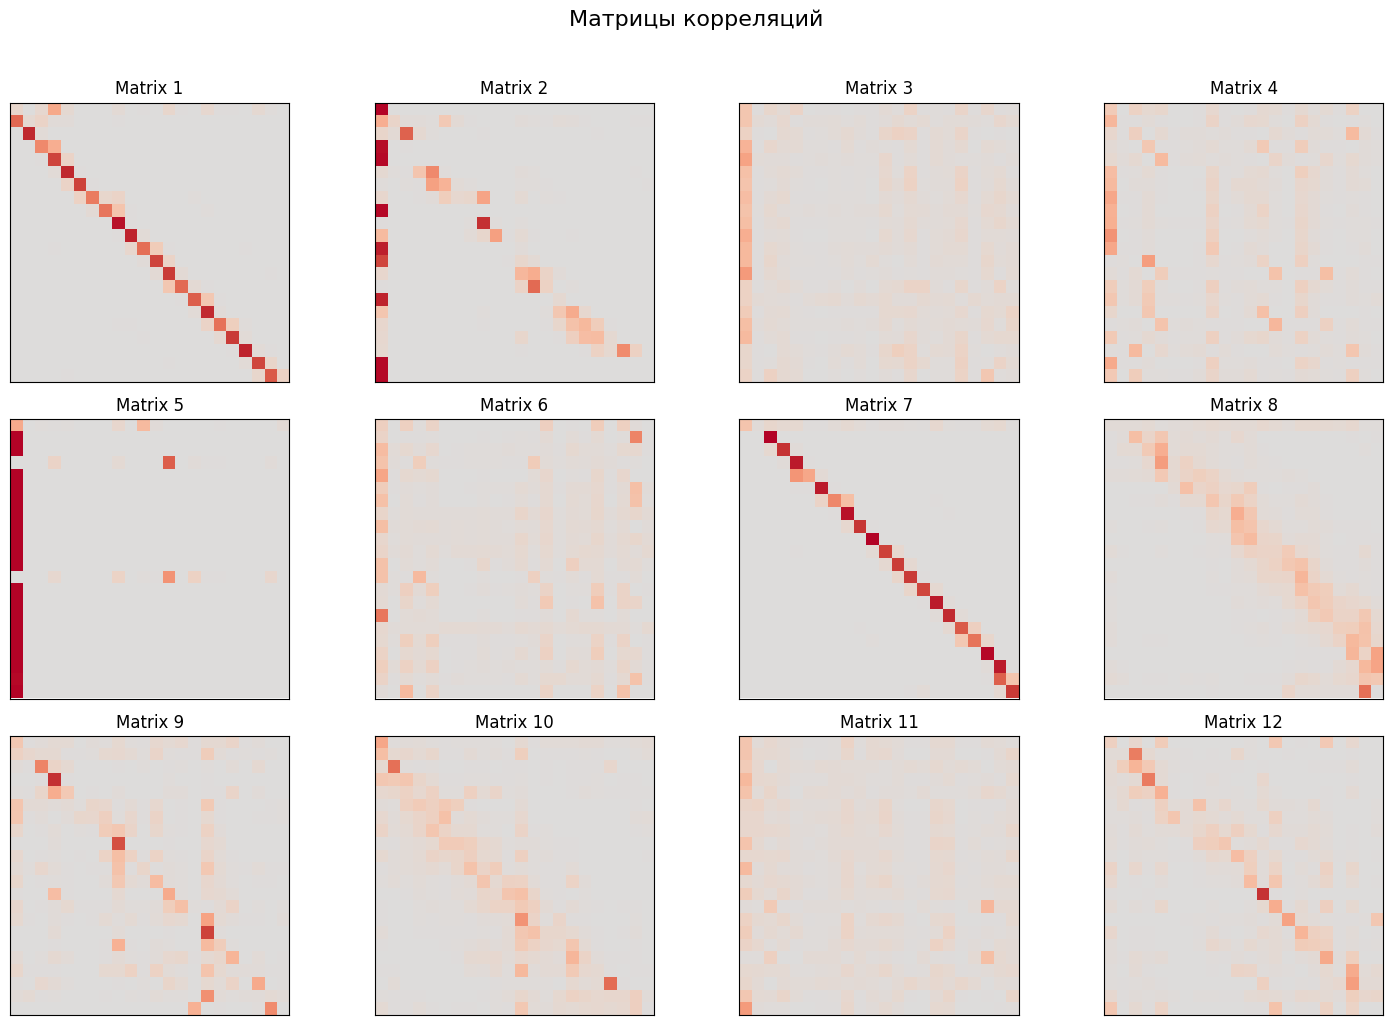

In [ ]:
print(ds['text'][2])
draw_first_layer_attention_maps(text = ds['text'][2], model=model, tokenizer=tokenizer)

In [ ]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_of_classes: int):
        super().__init__()
        self.backbone = base_transformer_model
        self.classificator = nn.Linear(768, num_of_classes)
        # YOUR CODE: create additional layers for classfication

    def forward(self, input_ids, token_type_ids = None, attention_mask=None, labels=None):
        # Pass input_ids and attention_mask to the backbone model
        outputs_from_BERT = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        #print(utputs_from_BERT.shape)
        # Use the pooled output for classification
        logits = self.classificator(outputs_from_BERT.pooler_output)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT')
model_for_func = model_for_func = BertModel.from_pretrained("tbs17/MathBERT")
model = TransformerClassificationModel(model_for_func, 7)

To prove that the sum of the numbers of the exact square cannot be equal to 5.
20
(12, 20, 20)


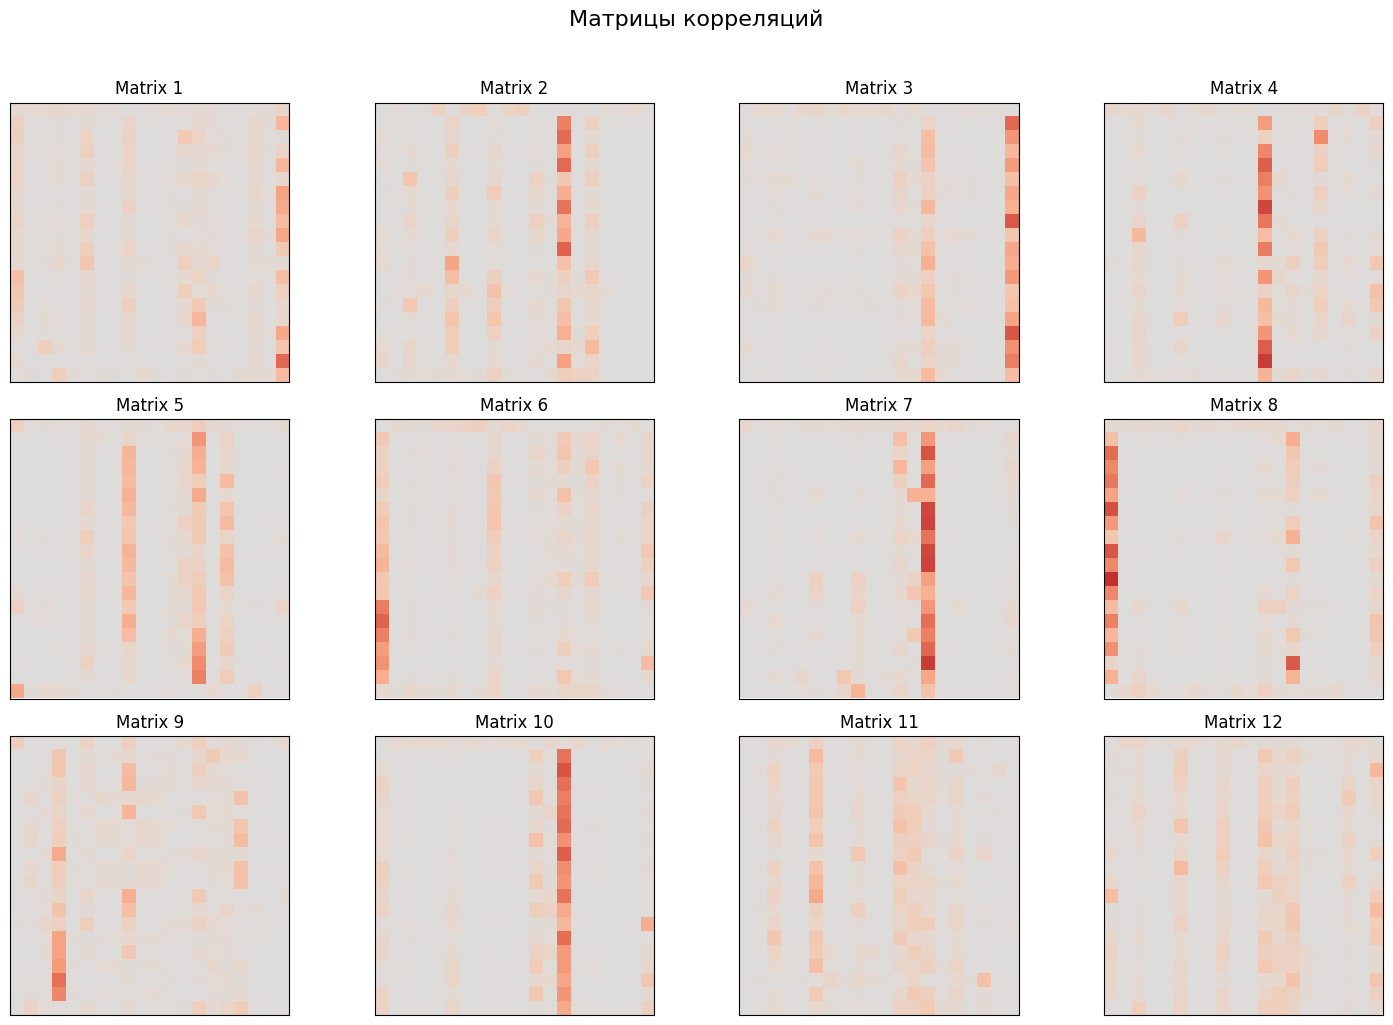

In [ ]:
print(ds_tr['text'][0])
draw_first_layer_attention_maps(text = ds_tr['text'][0], model=model, tokenizer=tokenizer)

# Видим, что английская и русская модели улавливают совсем разные паттерны! Интерпретировать отношения конкретных слов сложно. Так как в берте 1 токен != 1 слово. Также, можем видеть, что многие карты внимания, особенно в английскиой модели оценивают отношения одного токена с остальными (столбцы на графиках.)

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

В государстве 100 городов, и из каждого из них выходит 4 дороги. Сколько всего дорог в государстве?
22
(12, 22, 22)


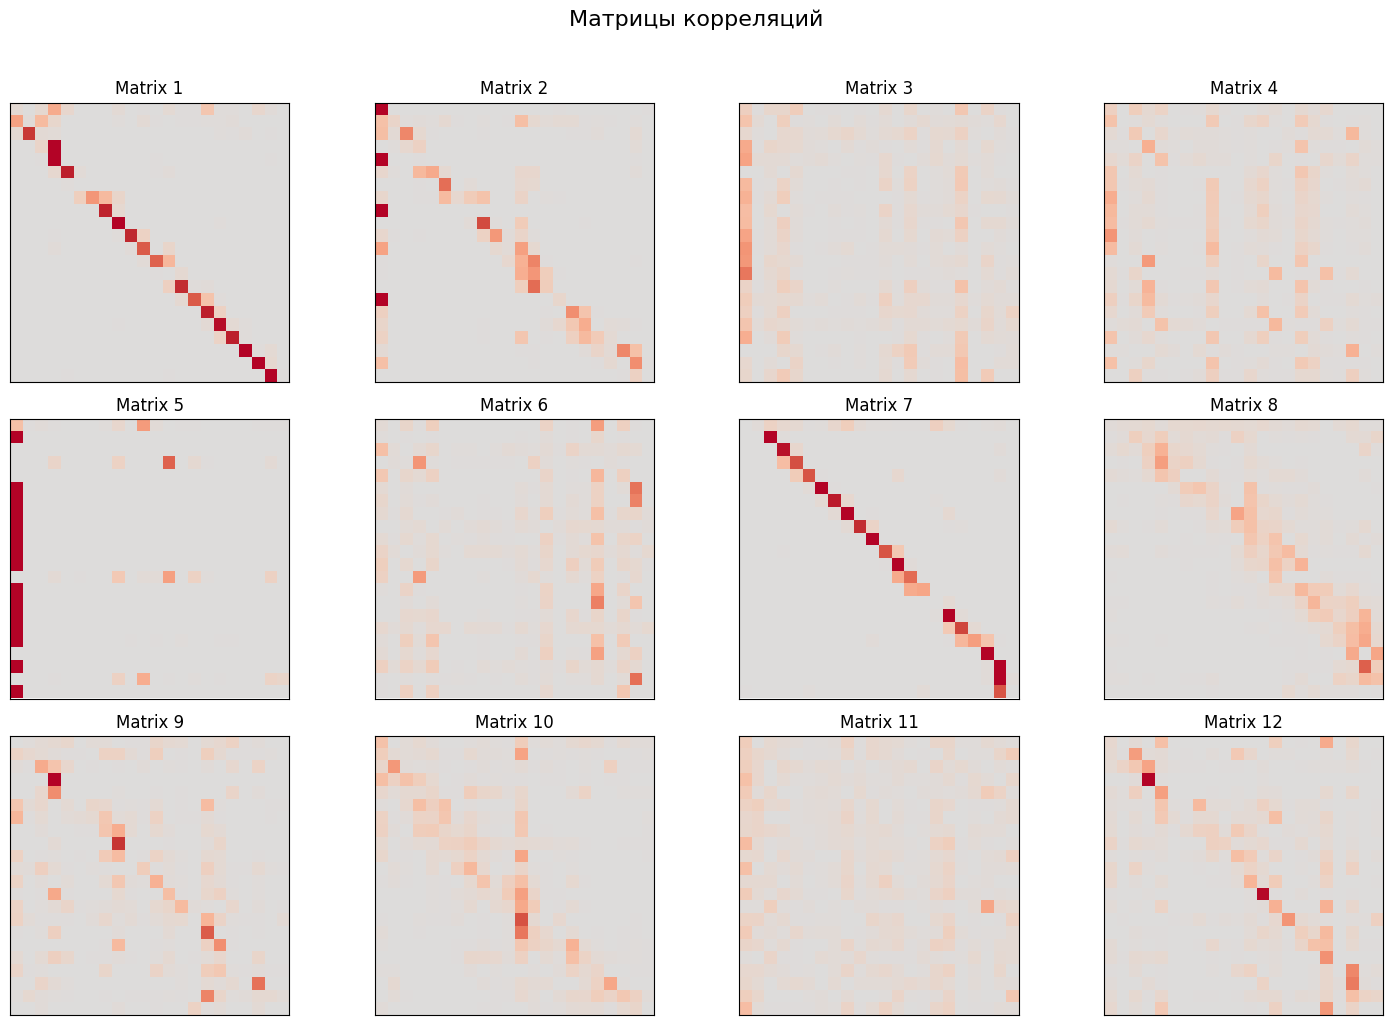

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
print(ds['text'][2])
draw_first_layer_attention_maps(text = ds['text'][2], model=rubert_tiny_finetuned_with_freezed_backbone, tokenizer=tokenizer)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT')

To prove that the sum of the numbers of the exact square cannot be equal to 5.
20
(12, 20, 20)


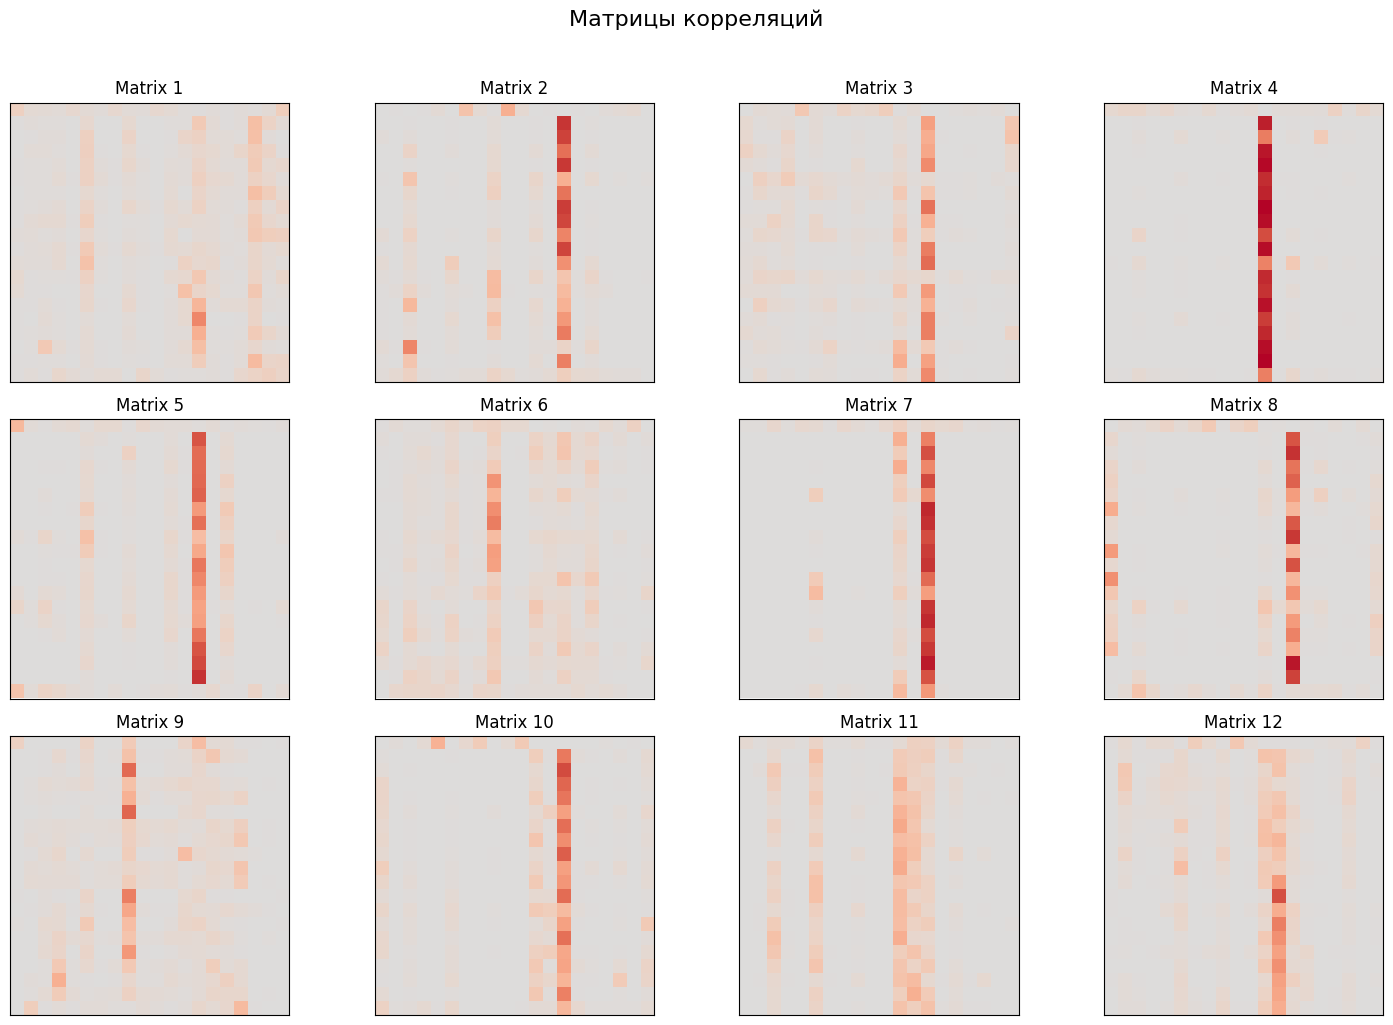

In [ ]:
print(ds_tr['text'][0])
draw_first_layer_attention_maps(text = ds_tr['text'][0], model=math_bert_full_finetuned, tokenizer=tokenizer)

# Можем заметить, что карты внимания немного изменились, при дообучении. Это говорит о том, что наши модели немного подстроились под наши данные. Но в целом, используя карты внимания сложо интерпетировать то, как читает предложение модель. А самое главное, что тут отображены только те токены, которые не являются падингами. Но берт наделяем весами и токены падингов, что еще сильнее усложняет интерпретацию...

f

f

ff

f

f

f

f

f

f

f

f

f

f

ff

f

f

f

f

f

f

f

f